In [1]:
import dgl
import torch
import torchtext

In [2]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import scipy.sparse as ssp
import torch
from builder import PandasGraphBuilder
from data_utils import *
import argparse

In [3]:
print(torch.__version__)

2.1.1


In [4]:
# parser = argparse.ArgumentParser()
# parser.add_argument('directory', type=str)
# parser.add_argument('output_path', type=str)
# args = parser.parse_args()
directory = './ml-1m'
output_path = './ml-graph-data.pkl'

In [5]:
# Load data
users = []
with open(os.path.join(directory, 'users.dat'), encoding='latin1') as f:
    for l in f:
        id_, gender, age, occupation, zip_ = l.strip().split('::')
        users.append({
            'user_id': int(id_),
            'gender': gender,
            'age': age,
            'occupation': occupation,
            'zip': zip_,
            })
users = pd.DataFrame(users).astype('category')

In [6]:
users.head()

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [7]:
movies = []
with open(os.path.join(directory, 'movies.dat'), encoding='latin1') as f:
    for l in f:
        id_, title, genres = l.strip().split('::')
        genres_set = set(genres.split('|'))

        # extract year
        assert re.match(r'.*\([0-9]{4}\)$', title)
        year = title[-5:-1]
        title = title[:-6].strip()

        data = {'movie_id': int(id_), 'title': title, 'year': year}
        for g in genres_set:
            data[g] = True
        movies.append(data)
movies = pd.DataFrame(movies).astype({'year': 'category'})

In [8]:
movies.head().iloc[:,:10]

,movie_id,title,year,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama
0,1,Toy Story,1995,True,True,True,NaN,NaN,NaN,NaN
1,2,Jumanji,1995,NaN,True,NaN,True,True,NaN,NaN
2,3,Grumpier Old Men,1995,NaN,NaN,True,NaN,NaN,True,NaN
3,4,Waiting to Exhale,1995,NaN,NaN,True,NaN,NaN,NaN,True
4,5,Father of the Bride Part II,1995,NaN,NaN,True,NaN,NaN,NaN,NaN


In [9]:
ratings = []
with open(os.path.join(directory, 'ratings.dat'), encoding='latin1') as f:
    for l in f:
        user_id, movie_id, rating, timestamp = [int(_) for _ in l.split('::')]
        ratings.append({
            'user_id': user_id,
            'movie_id': movie_id,
            'rating': rating,
            'timestamp': timestamp,
            })
ratings = pd.DataFrame(ratings)

In [10]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
# Filter the users and items that never appear in the rating table.
distinct_users_in_ratings = ratings['user_id'].unique()
distinct_movies_in_ratings = ratings['movie_id'].unique()
users = users[users['user_id'].isin(distinct_users_in_ratings)]
movies = movies[movies['movie_id'].isin(distinct_movies_in_ratings)]

In [12]:
# Group the movie features into genres (a vector), year (a category), title (a string)
genre_columns = movies.columns.drop(['movie_id', 'title', 'year'])
movies[genre_columns] = movies[genre_columns].fillna(False).astype('bool')
movies_categorical = movies.drop('title', axis=1)

In [13]:
# Build graph
graph_builder = PandasGraphBuilder()
graph_builder.add_entities(users, 'user_id', 'user')
graph_builder.add_entities(movies_categorical, 'movie_id', 'movie')
graph_builder.add_binary_relations(ratings, 'user_id', 'movie_id', 'watched')
graph_builder.add_binary_relations(ratings, 'movie_id', 'user_id', 'watched-by')
g = graph_builder.build()

In [14]:
# Assign features.
# Note that variable-sized features such as texts or images are handled elsewhere.
g.nodes['user'].data['gender'] = torch.LongTensor(users['gender'].cat.codes.values)
g.nodes['user'].data['age'] = torch.LongTensor(users['age'].cat.codes.values)
g.nodes['user'].data['occupation'] = torch.LongTensor(users['occupation'].cat.codes.values)
g.nodes['user'].data['zip'] = torch.LongTensor(users['zip'].cat.codes.values)

g.nodes['movie'].data['year'] = torch.LongTensor(movies['year'].cat.codes.values)
g.nodes['movie'].data['genre'] = torch.FloatTensor(movies[genre_columns].values)

g.edges['watched'].data['rating'] = torch.LongTensor(ratings['rating'].values)
g.edges['watched'].data['timestamp'] = torch.LongTensor(ratings['timestamp'].values)
g.edges['watched-by'].data['rating'] = torch.LongTensor(ratings['rating'].values)
g.edges['watched-by'].data['timestamp'] = torch.LongTensor(ratings['timestamp'].values)

/var/folders/n6/6b22wzr91csfxbb91pzg0sw00000gn/T/ipykernel_7004/2390254672.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  g.nodes['user'].data['gender'] = torch.LongTensor(users['gender'].cat.codes.values)


In [15]:
# Train-validation-test split
# This is a little bit tricky as we want to select the last interaction for test, and the
# second-to-last interaction for validation.
train_indices, val_indices, test_indices = train_test_split_by_time(ratings, 'timestamp', 'user_id')

/Users/ericsun/Desktop/CPSC 483 Final Project/CPSC-483-Final-Project/data_utils.py:21: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df = df.groupby(user, group_keys=False).apply(train_test_split).compute(scheduler='processes').sort_index()


    user_id  movie_id  rating  timestamp  train_mask  val_mask  test_mask
31        1      3186       4  978300019        True     False      False
27        1      1721       4  978300055        True     False      False
37        1      1022       5  978300055        True     False      False
22        1      1270       5  978300055        True     False      False
24        1      2340       3  978300103        True     False      False
36        1      1836       5  978300172        True     False      False
3         1      3408       4  978300275        True     False      False
47        1      1207       4  978300719        True     False      False
7         1      2804       5  978300719        True     False      False
21        1       720       3  978300760        True     False      False
0         1      1193       5  978300760        True     False      False
44        1       260       4  978300760        True     False      False
9         1       919       4  9783013

In [16]:
# Build the graph with training interactions only.
train_g = build_train_graph(g, train_indices, 'user', 'movie', 'watched', 'watched-by')
assert train_g.out_degrees(etype='watched').min() > 0

In [17]:
# Build the user-item sparse matrix for validation and test set.
val_matrix, test_matrix = build_val_test_matrix(g, val_indices, test_indices, 'user', 'movie', 'watched')

In [18]:
## Build title set
movie_textual_dataset = {'title': movies['title'].values}

In [19]:
## Dump the graph and the datasets
dataset = {
    'train-graph': train_g,
    'val-matrix': val_matrix,
    'test-matrix': test_matrix,
    'item-texts': movie_textual_dataset,
    'item-images': None,
    'user-type': 'user',
    'item-type': 'movie',
    'user-to-item-type': 'watched',
    'item-to-user-type': 'watched-by',
    'timestamp-edge-column': 'timestamp'}

with open(output_path, 'wb') as f:
    pickle.dump(dataset, f)

In [20]:
import pickle
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm

import layers
import sampler as sampler_module

In [21]:
class PinSAGEModel(nn.Module):
    def __init__(self, full_graph, ntype, item_features, hidden_dims, n_layers):
        super().__init__()

        self.proj = layers.LinearProjector(full_graph, ntype, item_features, hidden_dims)
        self.sage = layers.SAGENet(hidden_dims, n_layers)
        self.scorer = layers.ItemToItemScorer(full_graph, ntype)

    def forward(self, pos_graph, neg_graph, blocks):
        h_item = self.get_repr(blocks)
        pos_score = self.scorer(pos_graph, h_item)
        neg_score = self.scorer(neg_graph, h_item)
        return (neg_score - pos_score + 1).clamp(min=0)

    def get_repr(self, blocks):
        h_item = self.proj(blocks[0].srcdata)
        h_item_dst = self.proj(blocks[-1].dstdata)
        return h_item_dst + self.sage(blocks, h_item)

In [22]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset_path', type=str, default='./ml-graph-data.pkl')
parser.add_argument('--random-walk-length', type=int, default=2)
parser.add_argument('--random-walk-restart-prob', type=float, default=0.5)
parser.add_argument('--num-random-walks', type=int, default=10)
parser.add_argument('--num-neighbors', type=int, default=3)
parser.add_argument('--num-layers', type=int, default=2)
parser.add_argument('--hidden-dims', type=int, default=16)
parser.add_argument('--batch-size', type=int, default=32)
parser.add_argument('--device', type=str, default='cpu')        # can also be "cuda:0"
parser.add_argument('--num-epochs', type=int, default=5)
parser.add_argument('--batches-per-epoch', type=int, default=20000)
parser.add_argument('--num-workers', type=int, default=0)
parser.add_argument('--lr', type=float, default=3e-5)
parser.add_argument('-k', type=int, default=50)
args, unknown = parser.parse_known_args()

In [23]:
# Load dataset
with open(args.dataset_path, 'rb') as f:
    dataset = pickle.load(f)

In [24]:
g = dataset['train-graph']
val_matrix = dataset['val-matrix'].tocsr()
test_matrix = dataset['test-matrix'].tocsr()
item_texts = dataset['item-texts']
user_ntype = dataset['user-type']
item_ntype = dataset['item-type']
user_to_item_etype = dataset['user-to-item-type']
timestamp = dataset['timestamp-edge-column']

In [25]:
device = torch.device(args.device)

In [26]:
# Assign user and movie IDs and use them as features (to learn an individual trainable
# embedding for each entity)
g.nodes[user_ntype].data['id'] = torch.arange(g.number_of_nodes(user_ntype))
g.nodes[item_ntype].data['id'] = torch.arange(g.number_of_nodes(item_ntype))

In [27]:
import torch
from torchtext.vocab import Vocab, Vectors
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torch.utils.data import Dataset
from torchtext.vocab import FastText


# Define your tokenizer
tokenizer = get_tokenizer("basic_english")

# Process your data and build the counter
counter = Counter()
for key, texts in item_texts.items():
    for line in texts:
        counter.update(tokenizer(line))

# Sort the tokens to create a consistent ordered dictionary
sorted_vocab = sorted(counter.items(), key=lambda x: x[1], reverse=True)
stoi = {token: i for i, (token, _) in enumerate(sorted_vocab)}

# Load pre-trained word embeddings
vectors = FastText(language="simple")
# Create the Vocab object

# Map each token to its vector
embedding_dim = vectors.dim
vocab_vectors = torch.zeros(len(stoi), embedding_dim)
for token, idx in stoi.items():
    if token in vectors.stoi:
        vocab_vectors[idx] = vectors.vectors[vectors.stoi[token]]
    else:
        vocab_vectors[idx] = torch.zeros(embedding_dim)  # Zero vector for unknown words

# Define padding and unknown tokens
pad_token = "<pad>"
unk_token = "<unk>"

# Add padding and unknown tokens to the vocabulary
stoi[pad_token] = len(stoi)
stoi[unk_token] = len(stoi)

# Update the embeddings
# Add a zero vector for the padding token
# Add a random vector for the unknown token
padding_vector = torch.zeros(embedding_dim)
unknown_vector = torch.rand(embedding_dim)
vocab_vectors = torch.cat([vocab_vectors, padding_vector.unsqueeze(0), unknown_vector.unsqueeze(0)], 0)

class CustomDataset(Dataset):
    def __init__(self, item_texts, stoi, tokenizer, vocab_vectors, pad_token="<pad>"):
        self.data = []
        for i in range(len(item_texts[next(iter(item_texts.keys()))])):
            # Tokenize and numericalize here
            tokenized_texts = [tokenizer(item_texts[key][i]) for key in item_texts.keys()]
            numericalized_texts = [[stoi.get(token, stoi["<unk>"]) for token in text] for text in tokenized_texts]
            self.data.append(numericalized_texts)
            # Debugging: print out some samples
            if i < 5:
                print(numericalized_texts)

        self.stoi = stoi
        self.vocab_vectors = vocab_vectors
        self.pad_idx = self.stoi[pad_token]  # Index of the padding token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Pad sequences to the maximum length
        padded_sequence = [
            [self.stoi[token] if token in self.stoi else self.stoi["<unk>"] for token in sentence] +
            [self.pad_idx] * (self.max_length - len(sentence))
            for sentence in self.data[idx]
        ]
        return padded_sequence

# Instantiate your dataset
textset = CustomDataset(item_texts, stoi, tokenizer, vocab_vectors)

[[750, 30]]
[[1360]]
[[1361, 191, 51]]
[[364, 11, 1362]]
[[365, 2, 0, 101, 40, 15]]


In [28]:
# Sampler
batch_sampler = sampler_module.ItemToItemBatchSampler(g, user_ntype, item_ntype, args.batch_size)
neighbor_sampler = sampler_module.NeighborSampler(g, user_ntype, item_ntype, args.random_walk_length,
                                                  args.random_walk_restart_prob, args.num_random_walks,
                                                  args.num_neighbors, args.num_layers)
collator = sampler_module.PinSAGECollator(neighbor_sampler, g, item_ntype, textset)
dataloader = DataLoader(batch_sampler, collate_fn=collator.collate_train, num_workers=args.num_workers)
dataloader_test = DataLoader(torch.arange(g.number_of_nodes(item_ntype)), batch_size=args.batch_size,
                             collate_fn=collator.collate_test, num_workers=args.num_workers)
dataloader_it = iter(dataloader)

In [29]:
# Model
model = PinSAGEModel(g, item_ntype, textset, args.hidden_dims, args.num_layers).to(device)

In [30]:
# Optimizer
opt = torch.optim.Adam(model.parameters(), lr=args.lr)

  0%|          | 9/20000 [00:00<07:59, 41.66it/s]

1.0614343881607056


 25%|██▌       | 5009/20000 [01:39<05:16, 47.39it/s]

0.5455335974693298


 50%|█████     | 10010/20000 [05:11<03:12, 51.96it/s]

0.9540531635284424


 75%|███████▌  | 15004/20000 [06:51<02:13, 37.55it/s]

0.8749382495880127


  0%|          | 10/20000 [00:00<07:09, 46.56it/s]

0.7775083184242249


 25%|██▌       | 5010/20000 [01:55<05:25, 46.05it/s]

0.42713701725006104


 50%|█████     | 10005/20000 [03:47<03:44, 44.55it/s]

0.6166208386421204


 75%|███████▌  | 15007/20000 [05:41<01:48, 45.91it/s]

0.5594902038574219


  0%|          | 10/20000 [00:00<07:21, 45.26it/s]

0.4608379602432251


 25%|██▌       | 5007/20000 [01:50<05:37, 44.45it/s]

0.49006155133247375


 50%|█████     | 10004/20000 [04:10<09:00, 18.50it/s]

0.5015714168548584


 75%|███████▌  | 15004/20000 [07:46<03:16, 25.38it/s]

0.5501294732093811


  0%|          | 3/20000 [00:00<16:02, 20.78it/s]

0.4828697443008423


 25%|██▌       | 5003/20000 [03:45<12:14, 20.43it/s]

0.4331494867801666


 50%|█████     | 10005/20000 [07:23<06:35, 25.28it/s]

0.5311835408210754


 75%|███████▌  | 15005/20000 [10:06<02:27, 33.95it/s]

0.3090464770793915


  0%|          | 10/20000 [00:00<06:44, 49.42it/s]

0.5161339044570923


 25%|██▌       | 5008/20000 [01:53<05:48, 43.00it/s]

0.22741363942623138


 50%|█████     | 10005/20000 [03:53<03:48, 43.66it/s]

0.48637163639068604


 75%|███████▌  | 15007/20000 [05:50<01:50, 45.36it/s]

0.702155590057373


100%|██████████| 20000/20000 [07:45<00:00, 42.96it/s]


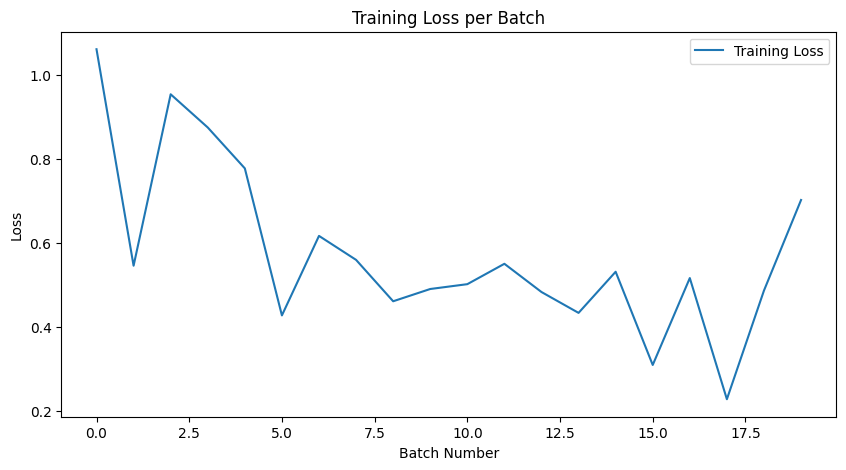

In [31]:
import matplotlib.pyplot as plt
import tqdm

# Initialize a list to store loss values
loss_values = []

for epoch_id in range(args.num_epochs):
    model.train()
    for batch_id in tqdm.trange(args.batches_per_epoch):
        pos_graph, neg_graph, blocks = next(dataloader_it)
        # Copy to GPU
        for i in range(len(blocks)):
            blocks[i] = blocks[i].to(device)
        pos_graph = pos_graph.to(device)
        neg_graph = neg_graph.to(device)

        loss = model(pos_graph, neg_graph, blocks).mean()
        opt.zero_grad()

        if batch_id % 5000 == 0:
            print(loss.item())

            # Record the loss value
            loss_values.append(loss.item())

        loss.backward()
        opt.step()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
torch.save(model, 'model.pth')

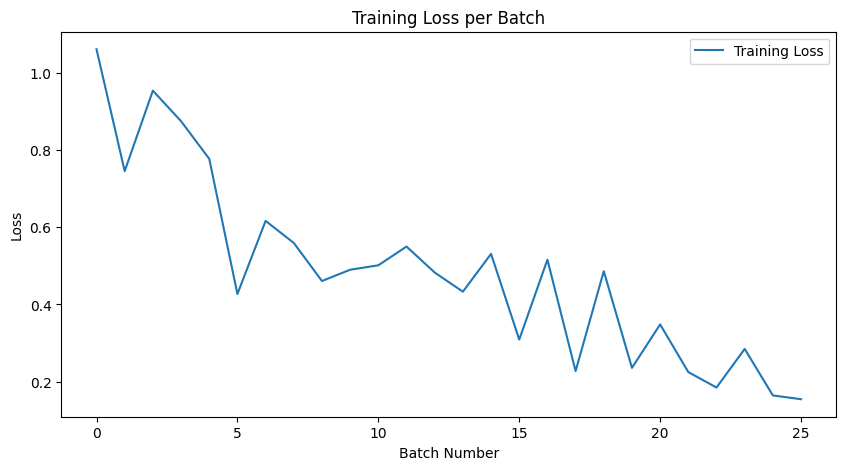

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
import evaluation

In [44]:
model1 = torch.load('model.pth')

model1.eval()
with torch.no_grad():
    for i in range(3):
        item_batches = torch.arange(g.number_of_nodes(item_ntype)).split(args.batch_size)
        h_item_batches = []
        for blocks in dataloader_test:
            for i in range(len(blocks)):
                blocks[i] = blocks[i].to(device)

            h_item_batches.append(model.get_repr(blocks))
        h_item = torch.cat(h_item_batches, 0)

        print(f"HIT@50: {evaluation.evaluate_nn(dataset, h_item, 50, args.batch_size)}")
        print(f"HIT@100: {evaluation.evaluate_nn(dataset, h_item, 100, args.batch_size)}")

HIT@50: 0.13741721854304637
HIT@100: 0.24668874172185432
HIT@50: 0.1357615894039735
HIT@100: 0.2533112582781457
HIT@50: 0.14072847682119205
HIT@100: 0.25
